In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import scipy.io as sio
from sklearn.neighbors import NearestNeighbors

In [2]:
pwd

u'/home/matsui-k/projects/d-rcn/scripts/core'

In [3]:
ms = sio.loadmat('/home/matsui-k/projects/d-rcn/dwsignsim/bdirs_whole_258.mat')

In [4]:
bdirs = ms['bdirs']

In [5]:
bdirs.shape

(3, 256)

In [6]:
ms = sio.loadmat('/home/matsui-k/projects/d-rcn/results/blind/pc/initial_1119/pred4.mat')

In [7]:
pred = ms['pred']

In [8]:
pred.shape

(855000, 256)

In [9]:
nbrs = NearestNeighbors(n_neighbors=7).fit(bdirs.T)

In [10]:
distances, knn_indices = nbrs.kneighbors(bdirs.T)

In [11]:
knn_indices

array([[  0,   1,   9, ...,   3,   2,  10],
       [  1,   6,   0, ...,   4,   5,   7],
       [  2,   7,   8, ...,   0,   9,  16],
       ..., 
       [253, 234, 233, ..., 252, 214, 116],
       [254, 235, 116, ...,  97, 234, 255],
       [255, 117, 236, ..., 235,  98, 254]])

In [12]:
knn_indices.shape

(256, 7)

In [13]:
pred.shape

(855000, 256)

In [22]:
knn_indices = results

In [23]:
start = time.clock()
valid_peak_indices_list = []
assert pred.shape[1] == bdirs.shape[1]
ratio = 0.2
for i_pred in xrange(100):
    s = pred[i_pred]
    local_max_indices_for_bdirs = []
    for i in range(s.shape[0]):
         if i == knn_indices[i][np.argmax(s[knn_indices[i]])]:
                local_max_indices_for_bdirs.append(i)
    indices_sorted_for_local_max = np.argsort(s[local_max_indices_for_bdirs])[::-2] # ソートしてから後ろから1ッコ飛ばしで
    max_index = indices_sorted_for_local_max[0]
    valid_peak_indices = []
    for i in indices_sorted_for_local_max:
        if s[local_max_indices_for_bdirs[i]] > s[local_max_indices_for_bdirs[max_index]] * ratio:
            valid_peak_indices.append(local_max_indices_for_bdirs[i])
            
    valid_peak_indices_list.append(valid_peak_indices)
    
time.clock() - start

0.17848600000000037

In [150]:
valid_peak_indices_list
print len(valid_peak_indices_list)

100


In [16]:
sio.savemat('/home/matsui-k/projects/d-rcn/dwsignsim/valid_peak_list.mat', {'valid_peak_list': valid_peak_indices_list})

In [17]:
from scipy.spatial import ConvexHull

In [18]:
ch = ConvexHull(bdirs.T)

In [19]:
ch.simplices

array([[206, 224, 188],
       [130, 136, 144],
       [146, 171, 157],
       ..., 
       [  8,  16,  28],
       [  8,  17,   9],
       [  8,  17,  28]], dtype=int32)

In [20]:
results = []
for i_dir in range(256):
    nn_indices_list = []
    for simplex in ch.simplices:
        if i_dir in simplex:
            nn_indices_list.extend(list(simplex))
    results.append(np.unique(nn_indices_list))

In [21]:
results

[array([ 0,  1,  2,  3,  4,  9, 10], dtype=int32),
 array([0, 1, 2, 4, 5, 6, 7], dtype=int32),
 array([ 0,  1,  2,  7,  8,  9, 16], dtype=int32),
 array([ 0,  3,  9, 10, 18, 19, 30], dtype=int32),
 array([ 0,  1,  4,  5, 10, 11, 12], dtype=int32),
 array([ 1,  4,  5,  6, 12, 13, 22], dtype=int32),
 array([ 1,  5,  6,  7, 13, 14, 24], dtype=int32),
 array([ 1,  2,  6,  7, 14, 15, 16], dtype=int32),
 array([ 2,  8,  9, 16, 17, 28], dtype=int32),
 array([ 0,  2,  3,  8,  9, 17, 18], dtype=int32),
 array([ 0,  3,  4, 10, 11, 19, 20], dtype=int32),
 array([ 4, 10, 11, 12, 20, 21, 32, 33], dtype=int32),
 array([ 4,  5, 11, 12, 21, 22], dtype=int32),
 array([ 5,  6, 13, 22, 23, 24, 36], dtype=int32),
 array([ 6,  7, 14, 15, 24, 25, 37], dtype=int32),
 array([ 7, 14, 15, 16, 25, 26, 39], dtype=int32),
 array([ 2,  7,  8, 15, 16, 26, 27, 28], dtype=int32),
 array([ 8,  9, 17, 18, 28, 29, 42], dtype=int32),
 array([ 3,  9, 17, 18, 29, 30, 43], dtype=int32),
 array([ 3, 10, 19, 20, 30, 31, 45], d


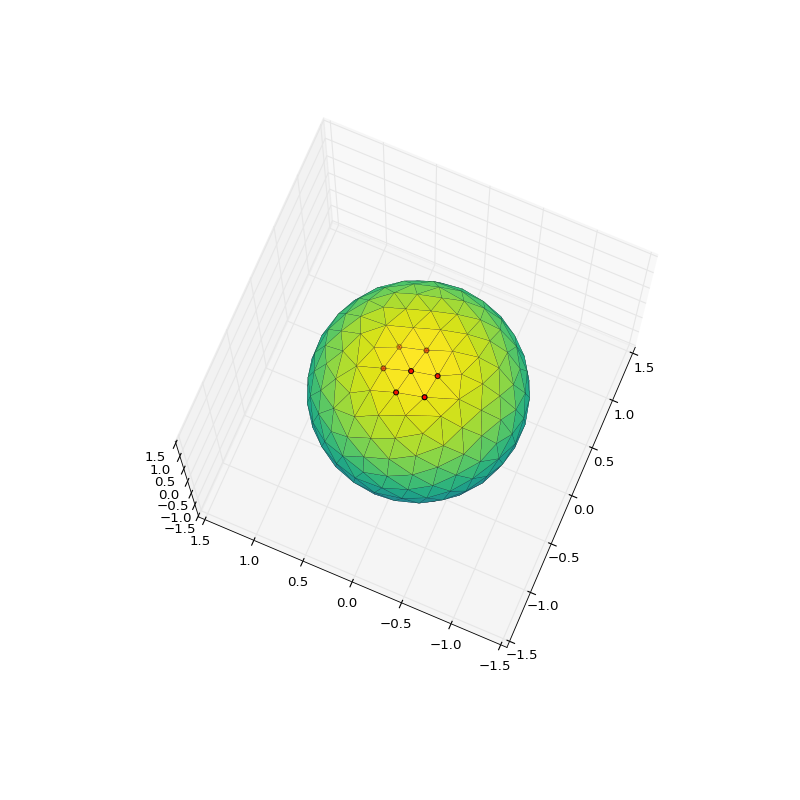

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d', aspect='equal')

# The triangles in parameter space determine which x, y, z points are
# connected by an edge
ax.plot_trisurf(bdirs[0], bdirs[1], bdirs[2], triangles=ch.simplices, cmap='viridis', linewidth=0.1, alpha=1)
i_dir = 1
ax.scatter3D(bdirs[0, results[i_dir]], bdirs[1, results[i_dir]], bdirs[2, results[i_dir]], c='r')
ax.view_init(90, 45+180)
plt.draw()

In [27]:
i = 6
i_pred = i
s = pred[i_pred]
peak_value_list = []
peak_dir_list = []
for i_peak in valid_peak_indices_list[i_pred]:
    nn_index = knn_indices[i_peak]
    nn_bdirs = bdirs[:, nn_index]
    # x.shape (dim=6, #nn=6 or 7)
    x = np.array([nn_bdirs[0]**2, nn_bdirs[1]**2, nn_bdirs[2]**2, nn_bdirs[0]*nn_bdirs[1], nn_bdirs[1]*nn_bdirs[2], nn_bdirs[2]*nn_bdirs[0]])
    # y.shape (#nn=6 or 7, )
    y = s[nn_index]
    w = np.dot(np.linalg.pinv(x.T), y) # w.shape (dim=6, )
    H = np.array([[w[0], w[3]/2, w[5]/2], [w[3]/2, w[1], w[4]/2], [w[5]/2, w[4]/2, w[2]]])
    e_val, e_vec = np.linalg.eigh(H)
    peak_value_list.append(e_val[-1])
    peak_dir_list.append(e_vec[:, -1])


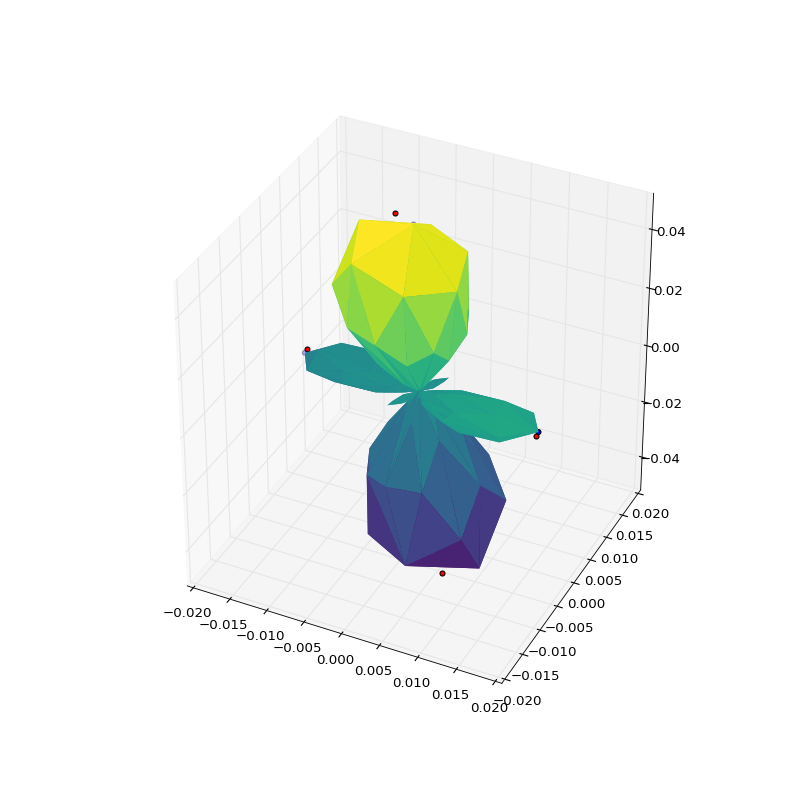

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
bw = s*bdirs
# The triangles in parameter space determine which x, y, z points are
# connected by an edge
ax.plot_trisurf(bw[0], bw[1], bw[2], triangles=ch.simplices, cmap='viridis', linewidth=0, alpha=1)
ax.scatter3D(bw[0, valid_peak_indices_list[i]], bw[1, valid_peak_indices_list[i]], bw[2, valid_peak_indices_list[i]])
ax.scatter3D(-bw[0, valid_peak_indices_list[i]], -bw[1, valid_peak_indices_list[i]], -bw[2, valid_peak_indices_list[i]])

for peak_value, peak_dir in zip(peak_value_list, peak_dir_list):
    b = peak_value * peak_dir
    ax.scatter3D(b[0], b[1], b[2], c='r')
    ax.scatter3D(-b[0], -b[1], -b[2], c='r')
ax.view_init(0, 45)

In [29]:
import blind_utils

In [30]:
peak_value_list, peak_dir_list = blind_utils.localmax(pred[:100])

In [31]:
peak_value_list

[[0.047712202489130169],
 [0.041327087351013911, 0.014769514364446734],
 [0.047129035740083161],
 [0.042813376726002002, 0.015010104322824078],
 [0.038267848465629126, 0.0098757470558694868],
 [0.033725333113202964, 0.011186550876853494],
 [0.040797208252617317, 0.019357279265160624],
 [0.0443080126780626, 0.010564290991792083],
 [0.034370851294298267, 0.020661308183153974, 0.010351501810818646],
 [0.046663016121029521],
 [0.040055640583303048, 0.012459610241337482],
 [0.047784425968055953],
 [0.045524343925861091],
 [0.048061302186011817],
 [0.0391814684207695, 0.0094233452211534164],
 [0.047641438475677728],
 [0.042252427298503537],
 [0.044419264601853997, 0.012793482601656296],
 [0.042774413443698103],
 [0.048105207203547856],
 [0.029336984891981797, 0.024188910147109825, 0.015336972901296321],
 [0.036599016258508719, 0.018083235734900352, 0.0095402103518827438],
 [0.045394842352830186, 0.011605308219610337],
 [0.047784919768051548],
 [0.04081726597673601],
 [0.047567478995053918],



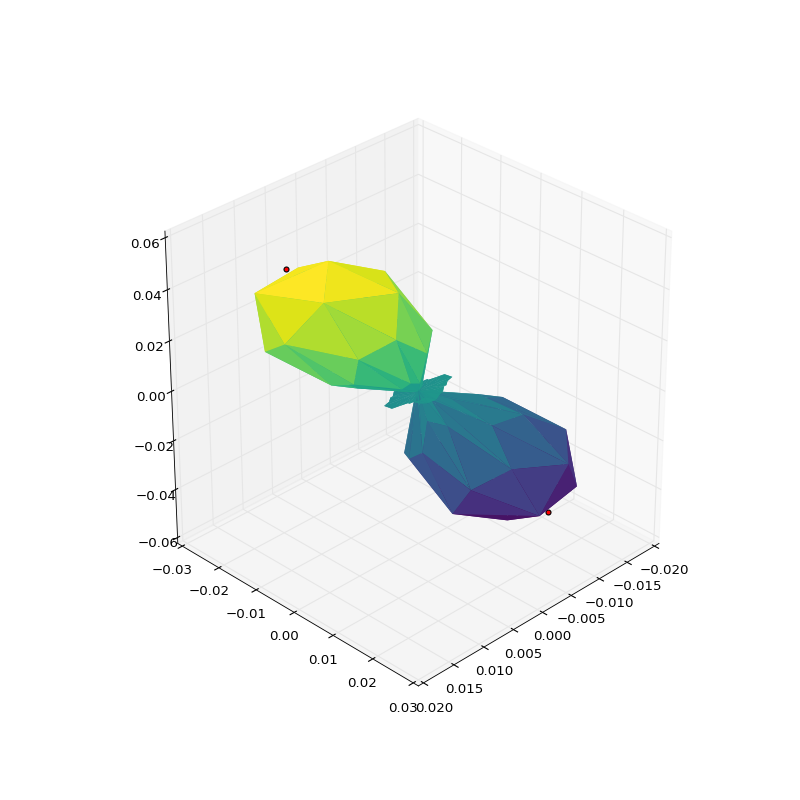

0.0479182948734


In [53]:
i  = np.random.randint(100)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
bw = pred[i]*bdirs
# The triangles in parameter space determine which x, y, z points are
# connected by an edge
ax.plot_trisurf(bw[0], bw[1], bw[2], triangles=ch.simplices, cmap='viridis', linewidth=0, alpha=1)
peak_values = peak_value_list[i]
peak_dirs = peak_dir_list[i]
for peak_value, peak_dir in zip(peak_values, peak_dirs):
    print peak_value
    b = peak_value * peak_dir + 0.0005
    ax.scatter3D(b[0], b[1], b[2], c='r')
    ax.scatter3D(-b[0], -b[1], -b[2], c='r')
ax.view_init(30, 45)